## TODO
1. Изменить константы в модели
2. Добавить больше признаков, в том числе задействующие 3 и более вершины

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

%matplotlib inline

Приготовим данные

In [3]:
import re

def line_processing(line):
    'для извлечения чисел из матриц'
    line = re.split('[^0-9,.,]+', line)
    i = 0
    while(i < len(line)):
        if(line[i] == ''):
            line.pop(i)
        else:
            i += 1
    return line

def read_matrix_row(file):
    line = file.readline()
    while(line[-2] != ']'):
        tmp = file.readline()
        line += tmp
    return line_processing(line)

def read_matrix(file):
    line = read_matrix_row(file)
    #количество атомов
    n  = len(line)
    
    result = []
    for i in range(n):
        row = []
        if(n > len(line)):
            print("hi", i)
            print(line)
        for j in range(n):
            row.append(float(line[j]))
        if(i < n - 1):
            line = read_matrix_row(file)
        result.append(row)
    return np.array(result)

def read_atoms_features_and_labels(file, n): 
    features = []
    labels = []
    for _ in range(n):
        line = file.readline()
        line = line.split()
        #add as features element electronegativity, is in ring, triple product
        #if triple product is None, we consider it 0
        features.append([float(line[3]), float(line[7]), 0.0 if line[8] == 'None' else float(line[8])])
        #type2 is a label
        labels.append(float(line[4]))
    return np.array(features), np.array(labels)

In [3]:
def read_molecule(path):
    file = open(path, 'r')
    file.readline()
    adjacency_matrix = read_matrix(file)
    file.readline()
    distance_matrix = torch.from_numpy(read_matrix(file)).float()
    
    for _ in range(3):
        file.readline()
    atoms_features, atoms_labels = read_atoms_features_and_labels(file, distance_matrix.shape[0])
    atoms_features = Variable(torch.from_numpy(atoms_features).float())
    atoms_labels = Variable(torch.from_numpy(atoms_labels).float())
    
    file.readline()
    bond_length = torch.from_numpy(read_matrix(file)).float()
    file.readline()
    same_ring = torch.from_numpy(read_matrix(file)).float()
    pairs_features = Variable(torch.cat([distance_matrix[..., np.newaxis], bond_length[..., np.newaxis],
                                         same_ring[..., np.newaxis]], dim=2))
    
    file.close()
    
    # Проверим, что всё хорошо считали
    assert(adjacency_matrix.shape[0] == adjacency_matrix.shape[1])
    assert(distance_matrix.shape[0] == distance_matrix.shape[1])
    assert(bond_length.shape[0] == bond_length.shape[1])
    assert(same_ring.shape[0] == same_ring.shape[1])
    assert(distance_matrix.shape[0] == adjacency_matrix.shape[1])
    assert(bond_length.shape[0] == adjacency_matrix.shape[1])
    assert(same_ring.shape[0] == adjacency_matrix.shape[1])
    
    #Теперь приготовим входные данные для сети
    #inputs_a = Variable(torch.Tensor(atoms_features.shape[0], 1, atoms_features.shape[0], atoms_features.shape[1]))
    #inputs_p = Variable(torch.Tensor(atoms_features.shape[0], 1, pairs_features.shape[0], pairs_features.shape[1], pairs_features.shape[2]))
    #for i in range(atoms_features.shape[0]):
    #    inputs_a[i] = atoms_features
    #    inputs_p[i] = pairs_features
    labels=atoms_labels.long()
    labels.add_(-1)
    
    inputs_a = Variable(torch.Tensor(1, 1, atoms_features.shape[0], atoms_features.shape[1]))
    inputs_p = Variable(torch.Tensor(1, 1, pairs_features.shape[0], pairs_features.shape[1], pairs_features.shape[2]))
    inputs_a[0] = atoms_features
    inputs_p[0] = pairs_features
    labels = labels[np.newaxis, ..., np.newaxis]
    
    return [inputs_a, inputs_p, adjacency_matrix, labels]

In [4]:
train = []
test = []
# путь к директории, где лежат модели
data_path = "mol-descs/descs/"
pathes = os.listdir(path=data_path)
pathes = [path for path in pathes if path[-4:] == '.dat']

In [5]:
for path in pathes[:1000]:
    data = read_molecule(data_path + path)
    train.append(data)

In [6]:
test = train[-200:]
train = train[:-200]

Теперь сама сеть

In [7]:
class Net(nn.Module):
    def __init__(self, wave_modules_count=1):
        super(Net, self).__init__()
        self.wave_modules_count = wave_modules_count
        self.C = 6
        self.conv1 = nn.Conv1d(1, self.C, 3)
        self.conv2 = nn.Conv1d(1, self.C, 3)
        self.fc1 = nn.Linear(2 * self.C, 4)
        self.dropout = nn.Dropout(p=0.5)
    
    def wave_module(self, x, y, adjacency_matrix):
        # (A->A)
        "TODO заменить константу в размере вектора"
        x1 = Variable(torch.Tensor(x.shape[0], self.C, x.shape[2], 1))
        for i in range(x1.shape[2]):
            x1[:, :, i] = F.relu(self.conv1(x[:, :, i]))
        #print("x1:", float(x1.max()), float((-x1).max()))
        
        # (P->P)
        "TODO заменить константу в размере вектора"
        y1 = Variable(torch.Tensor(y.shape[0], self.C, y.shape[2], y.shape[3], 1))
        for i in range(y1.shape[2]):
            for j in range(y1.shape[3]):
                y1[:, :, i, j] = F.relu(self.conv2(y[:, :, i, j]))
        #print("y1:", float(y1.max()), float((-y1).max()))
        
        # (P->A)
        # сначала получим для каждой вершины смежные вершины
        edges = []
        for i in range(adjacency_matrix.shape[0]):
            tmp = []
            for j in range(len(adjacency_matrix[i])):
                if(adjacency_matrix[i][j] == 1):
                    tmp.append(j)
            edges.append(tmp)
        # теперь непосредственно получаем новый слой, используя y1
        "TODO заменить константу в размере вектора"
        x2 = Variable(torch.Tensor(x.shape[0], self.C, x.shape[2], 1))
        for i in range(x2.shape[2]):
            x2[:, :, i] = y1[:, :, i, edges[i][0]]
            #print("x2_sub:", float(x2.max()), float((-x2).max()))
            for j in range(1, len(edges[i])):
                x2[:, :, i] = x2[:, :, i] + y1[:, :, i, edges[i][j]]
            #print("x2_sub:", float(x2.max()), float((-x2).max()))
            #x2[:, :, i] = torch.sum([y1[:, :, i, b] for b in edges[i]], dim=2)
        #print("x2:", float(x2.max()), float((-x2).max()))
        
        # (A -> P)
        "TODO заменить константу в размере вектора"
        y2 = Variable(torch.Tensor(y.shape[0], self.C, y.shape[2], y.shape[3], 4))
        for i in range(y2.shape[2]):
            for j in range(y2.shape[3]):
                y2[:, :, i, j] = torch.add(F.relu(self.conv1(torch.cat([x[:, :, i], x[:, :, j]], dim=2))),
                           F.relu(self.conv1(torch.cat([x[:, :, j], x[:, :, i]], dim=2))) )
        #print("y2:", float(y2.max()), float((-y2).max()))
        
        # теперь плучаем новые атомный и парный слои
        x_ret = torch.cat([x1, x2], dim = 3)
        y_ret = torch.cat([y1, y2], dim = 4)
        
        return [x_ret, y_ret]
        
    def forward(self, x, y, adjacency_matrix):
        #print("zero:", float(x.max()), float((-x).max()))
        for _ in range(self.wave_modules_count):
            x, y = self.wave_module(x, y, adjacency_matrix)
        
        #print("first:", float(x.max()), float((-x).max()))
        x = x.view(x.shape[0], adjacency_matrix.shape[0], -1)
        #print("second:", float(x.max()), float((-x).max()))
        x = self.fc1(x)
        x = x.transpose(1, 2)
        x = x[..., np.newaxis]
        #print(x[:, :, :5])
        
        x = self.dropout(x)
        #print("third:", float(x.max()), float((-x).max()))
        return x

Параметры оптимизатора взяты из статьи

In [4]:
loss_iterations_train = np.load('error.npy').tolist()
loss_iterations_test = []

In [9]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters(), lr=0.003)

In [ ]:
poses = np.random.choice(np.arange(0, len(train)), size=len(train))

for epoch in range(2):  # loop over the dataset multiple times
    appopr_data_pos = 0
    running_loss = 0.0
    for pos in tqdm(poses):
        # get the inputs
        inputs_a, inputs_p, adjacency_matrix, labels = train[pos]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs_a, inputs_p, adjacency_matrix)
        #print(outputs[:, :, :5])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]

        if appopr_data_pos % 300 == 299:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, appopr_data_pos + 1, running_loss / 300))
            running_loss = 0.0
        appopr_data_pos += 1
        

 51%|█████     | 407/800 [07:15<07:00,  1.07s/it]

In [19]:
np.save('error.npy', np.array(loss_iterations))
np.save('error_test.npy', np.array(loss_iterations_test))

In [7]:
std = np.std(loss_iterations_train, axis=0)
mean = np.mean(loss_iterations_train, axis=0)

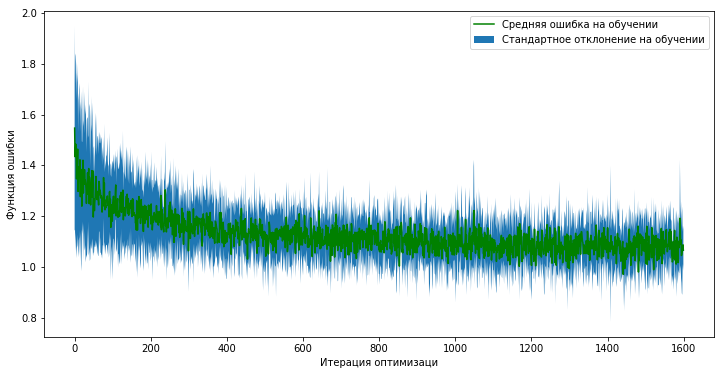

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, len(loss_iterations_train[0])), mean, color='green', label='Средняя ошибка на обучении')
plt.fill_between(np.arange(0, len(loss_iterations_train[0])), mean - std, mean + std, label='Стандартное отклонение на обучении')
plt.xlabel('Итерация оптимизаци')
plt.ylabel('Функция ошибки')
plt.legend()
plt.savefig('testplot.jpg', dpi=1000)
#Image.open('testplot.png').save('testplot.jpg','JPEG')
plt.show()

In [16]:
loss_test = []

In [17]:
for i in range(10):
    correct = 0
    total = 0
    poses = np.random.choice(np.arange(0, len(test)), size=len(test))
    for pos in tqdm(poses):
        inputs_a, inputs_p, adjacency_matrix, labels = test[pos]
        outputs = net(inputs_a, inputs_p, adjacency_matrix)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(1) * labels.size(0)
        correct += (predicted == labels.data).sum()
    loss_test.append(float(correct) / total)

100%|██████████| 200/200 [01:47<00:00,  1.85it/s]


In [19]:
np.mean(loss_test), np.std(loss_test)

(0.4592881657775908, 0.006995038726583188)